In [1]:
from sklearn.model_selection import train_test_split
from src.baseline_experiments import *
import pandas as pd
import sklearn
import numpy as np
import glob
from mountaineer import Mountaineer
from gale import create_mapper

## Import Diabetes dataset

In [2]:
np.random.seed(2022)
torch.manual_seed(2022)

df = pd.read_csv("./dataset/diabetes.csv")
df.drop(columns=["p_id"], inplace=True)

In [3]:
X = df.drop(columns=["diabetes"])
y = df["diabetes"]

## Train a neural network model with two hidden layers

In [4]:
batch_size = 16
num_epochs = 80
learning_rate = 4e-3
N = 100
shap_sample_size = 10
#possible blur/mean/zero
imputation_typ = 'blur'


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
X_train_tens = torch.tensor(X_train.to_numpy()).float()
X_test_tens = torch.tensor(X_test.to_numpy()).float()

In [6]:
unique, counts = np.unique(y_train, return_counts=True)
    
averaging = 'binary'
y_train_tens = torch.tensor(y_train.to_numpy()).view(-1, 1).float()
output_dim = 1

In [7]:
device = torch.device("cpu")

dataset_tens = torch.utils.data.TensorDataset(X_train_tens, y_train_tens)
train_iter = torch.utils.data.DataLoader(dataset_tens, batch_size, shuffle=False)

print("Try to load the model..")
model = nn_model.get_model(device, train_iter, X_train.shape[1], output_dim, averaging, learning_rate, num_epochs)

Try to load the model..
Train model
Epoch 020: | Loss: 0.31699 | Acc: 87.423 | F1: 80.41322
Epoch 040: | Loss: 0.22922 | Acc: 92.115 | F1: 87.63696
Epoch 060: | Loss: 0.32565 | Acc: 86.000 | F1: 78.44096
Epoch 080: | Loss: 0.26615 | Acc: 88.385 | F1: 81.75308
Set to eval


In [8]:
X_test_tens = torch.tensor(X_test.to_numpy()).float()

X_test_c, Y_test_c = get_correct_predictions(model,X_test.reset_index(drop=True),X_test_tens,y_test.reset_index(drop=True),averaging)
X_test_c_tens = torch.from_numpy(X_test_c.to_numpy(dtype=np.float32))

X_test of correct predictions shape: (152, 8)
Y_test of correct predictions shape: (152,)
Label in Y_test of correct predictions ratio: 
 [[  0 110]
 [  1  42]]


## Use the sigmoid function as the prediction probability function for Mapper

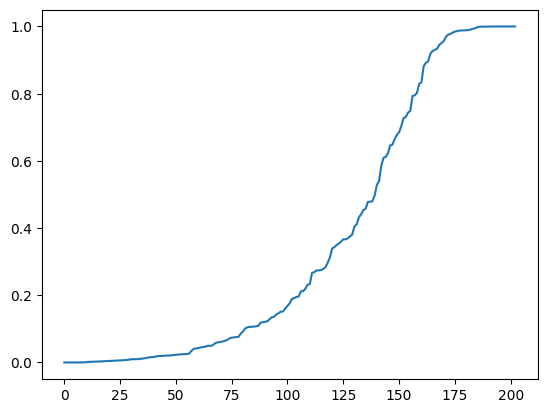

In [9]:
predictions = torch.sigmoid(model(X_test_tens)).detach().numpy()
plt.plot(np.sort(predictions.flatten()))

## Compute the Explanations of (IntGrad, SHAP, DeepLIFT) $\times$ (Zero, Max Distances, Uniform, Gaussian, Train)-Baselines (15 explanation outputs in total)


In [10]:
print("Loading all baselines..")
bun = BaselineUtilTensor()
black_baseline = bun.create_black_baseline(X)
uniform_baseline = bun.create_uniform_baseline(X)
gaussian_baseline = bun.create_gaussian_baseline(X, 0.5)
train_baseline = bun.create_train_baseline(X)

Loading all baselines..


In [11]:
explanations = {}
methods = ['IG','DeepSHAP','DeepLIFT']
target = None
for method in methods:
    bb_attr, mdb_attr, ub_attr, gb_attr, tb_attr = get_attr_scores(method, X_test_tens, None, black_baseline,uniform_baseline,gaussian_baseline, train_baseline, model,X.min(), X.max(), X.columns)
    explanations[method] = [bb_attr, mdb_attr, ub_attr, gb_attr, tb_attr]
    #for exp in explanations[method]:
        #exp[exp>5]=5
        #exp[exp<-5]=-5

Start integrated gradients for correct predictions with black_baseline
--- '0.19' seconds computation time ---
Start integrated gradients for correct predictions with max_dist_baseline
--- '0.86' seconds computation time ---
Start integrated gradients for correct predictions with uniform_baseline
--- '1.77' seconds computation time ---
Start integrated gradients for correct predictions with gaussian_baseline
--- '1.83' seconds computation time ---
Start integrated gradients for correct predictions with train_baseline
--- '1.73' seconds computation time ---
Start DeepSHAP for correct predictions with black_baseline
--- '0.21' seconds computation time ---
Start DeepSHAP for correct predictions with max_dist_baseline
--- '0.30' seconds computation time ---
Start DeepSHAP for correct predictions with uniform_baseline
--- '1.97' seconds computation time ---
Start DeepSHAP for correct predictions with gaussian_baseline
--- '1.89' seconds computation time ---
Start DeepSHAP for correct predic

In [12]:
#baselines = ['zero', 'max distance', 'uniform', 'gaussian', 'trained']

## Creating the mapper outputs

In [13]:
import sklearn
mapper1 = create_mapper(explanations['IG'][0], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper2 = create_mapper(explanations['IG'][1], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper3 = create_mapper(explanations['IG'][2], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper4 = create_mapper(explanations['IG'][3], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper5 = create_mapper(explanations['IG'][4], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))

mapper6 = create_mapper(explanations['DeepSHAP'][0], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper7 = create_mapper(explanations['DeepSHAP'][1], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper8 = create_mapper(explanations['DeepSHAP'][2], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper9 = create_mapper(explanations['DeepSHAP'][3], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper10 = create_mapper(explanations['DeepSHAP'][4], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))


mapper11 = create_mapper(explanations['DeepLIFT'][0], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper12 = create_mapper(explanations['DeepLIFT'][1], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper13 = create_mapper(explanations['DeepLIFT'][2], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper14 = create_mapper(explanations['DeepLIFT'][3], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))
mapper15 = create_mapper(explanations['DeepLIFT'][4], np.array([np.squeeze(i) for i in predictions]), resolution=10, gain=0.5, dist_thresh=0.5, clusterer=sklearn.cluster.KMeans(n_clusters=2,random_state=3471))


In [14]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:1920px !important; }</style>"))

In [46]:
#visualize
test = Mountaineer()
#list of mapper outputs - minimum 2
mapper_outputs=[mapper1, mapper2, mapper3, mapper4, mapper5, mapper6, mapper7, mapper8, mapper9, mapper10, mapper11, mapper12, mapper13, mapper14, mapper15]
#array of what we want the values to be colored by by default(In this case we are simply passing the lens - ie. Prediction Probabilities)
color_values = [np.array([np.squeeze(i) for i in predictions])]
#column names of the dataframe
column_names= np.array(X.columns)
test.visualize(X_test.to_numpy(),y_test.to_numpy(), mapper_outputs, color_values, column_names, 'UMAP') #Projection method- 'UMAP' or 'TSNE'